In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda', index=0)

In [2]:
df = pd.read_csv("/kaggle/input/ai-vs-human-text/AI_Human.csv")
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
df['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

In [4]:
df['generated'] = df['generated'].astype(int)

In [5]:
df['generated'].value_counts()

generated
0    305797
1    181438
Name: count, dtype: int64

In [6]:
df_0 = df[df['generated'] == 0].copy()
df_1 = df[df['generated'] == 1].copy()


In [7]:
df_0= df_0[:3000]
df_1= df_1[:3000]

In [8]:
df = pd.concat([df_0,df_1], ignore_index=True)
df

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
5995,\nWhen considering the pros and cons of decidi...,1
5996,\nHaving a positive attitude is essential for ...,1
5997,\nBefore the invention and widespread use of t...,1
5998,\nOlder students within a school system have t...,1


# **Data Distribution**

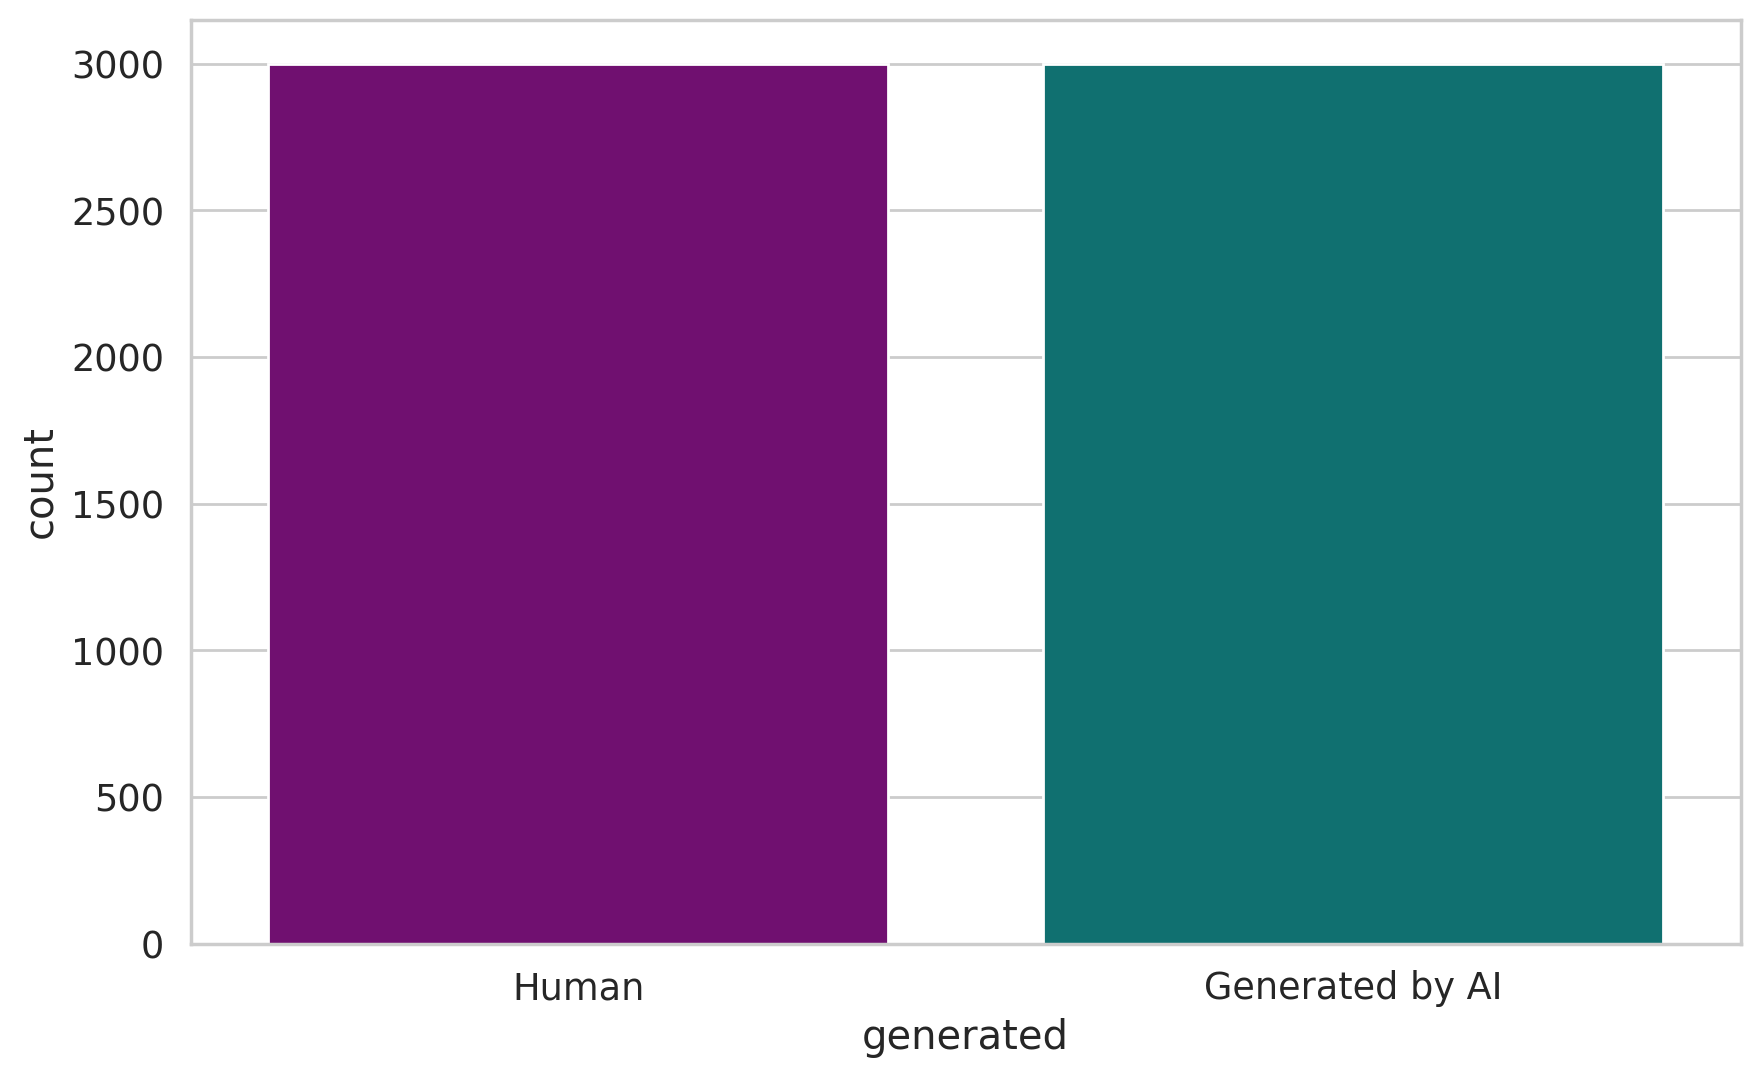

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))
class_names = ['Human', 'Generated by AI']
custom_palette = ['Purple', 'teal']

sns.countplot(x='generated', data=df, palette=custom_palette)

plt.gca().set_xticklabels(class_names)

plt.show()


In [10]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_data(data, title):
    # Calculate text length for each entry in the 'text' column and store the results in a new column
    data['text_length'] = data['text'].apply(len)
    
    # Calculate word count for each entry in the 'text' column and store the results in a new column
    data['text_word_count'] = data['text'].apply(lambda x: len(str(x).split()))

    # Create a figure with a larger size
    plt.figure(figsize=(16, 8))

    # Define a custom font with a nice appearance
    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    # First subplot for text length distribution
    plt.subplot(1, 2, 1)
    n, bins, patches = plt.hist(data['text_length'], bins=10, color='mediumaquamarine', edgecolor='black', alpha=0.5, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Annotate the plot with bin values (vertical text)
    for bin_val, freq in zip(bins, n):
        plt.text(bin_val+100, freq+20, f'{int(freq)}', ha='left', va='baseline', fontsize=12, fontproperties=custom_font)

    # Second subplot for word count distribution
    plt.subplot(1, 2, 2)
    n, bins, patches = plt.hist(data['text_word_count'], bins=10, color='violet', edgecolor='black', alpha=0.7, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Word Count", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Word Count Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Annotate the plot with bin values (vertical text)
    for bin_val, freq in zip(bins, n):
        
        plt.text(bin_val+20, freq+20, f'{int(freq)}', ha='left', va='baseline', fontsize=12, fontproperties=custom_font)

    # Adjust the layout for subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# visualize_text_data(your_data_frame, "Your Title")


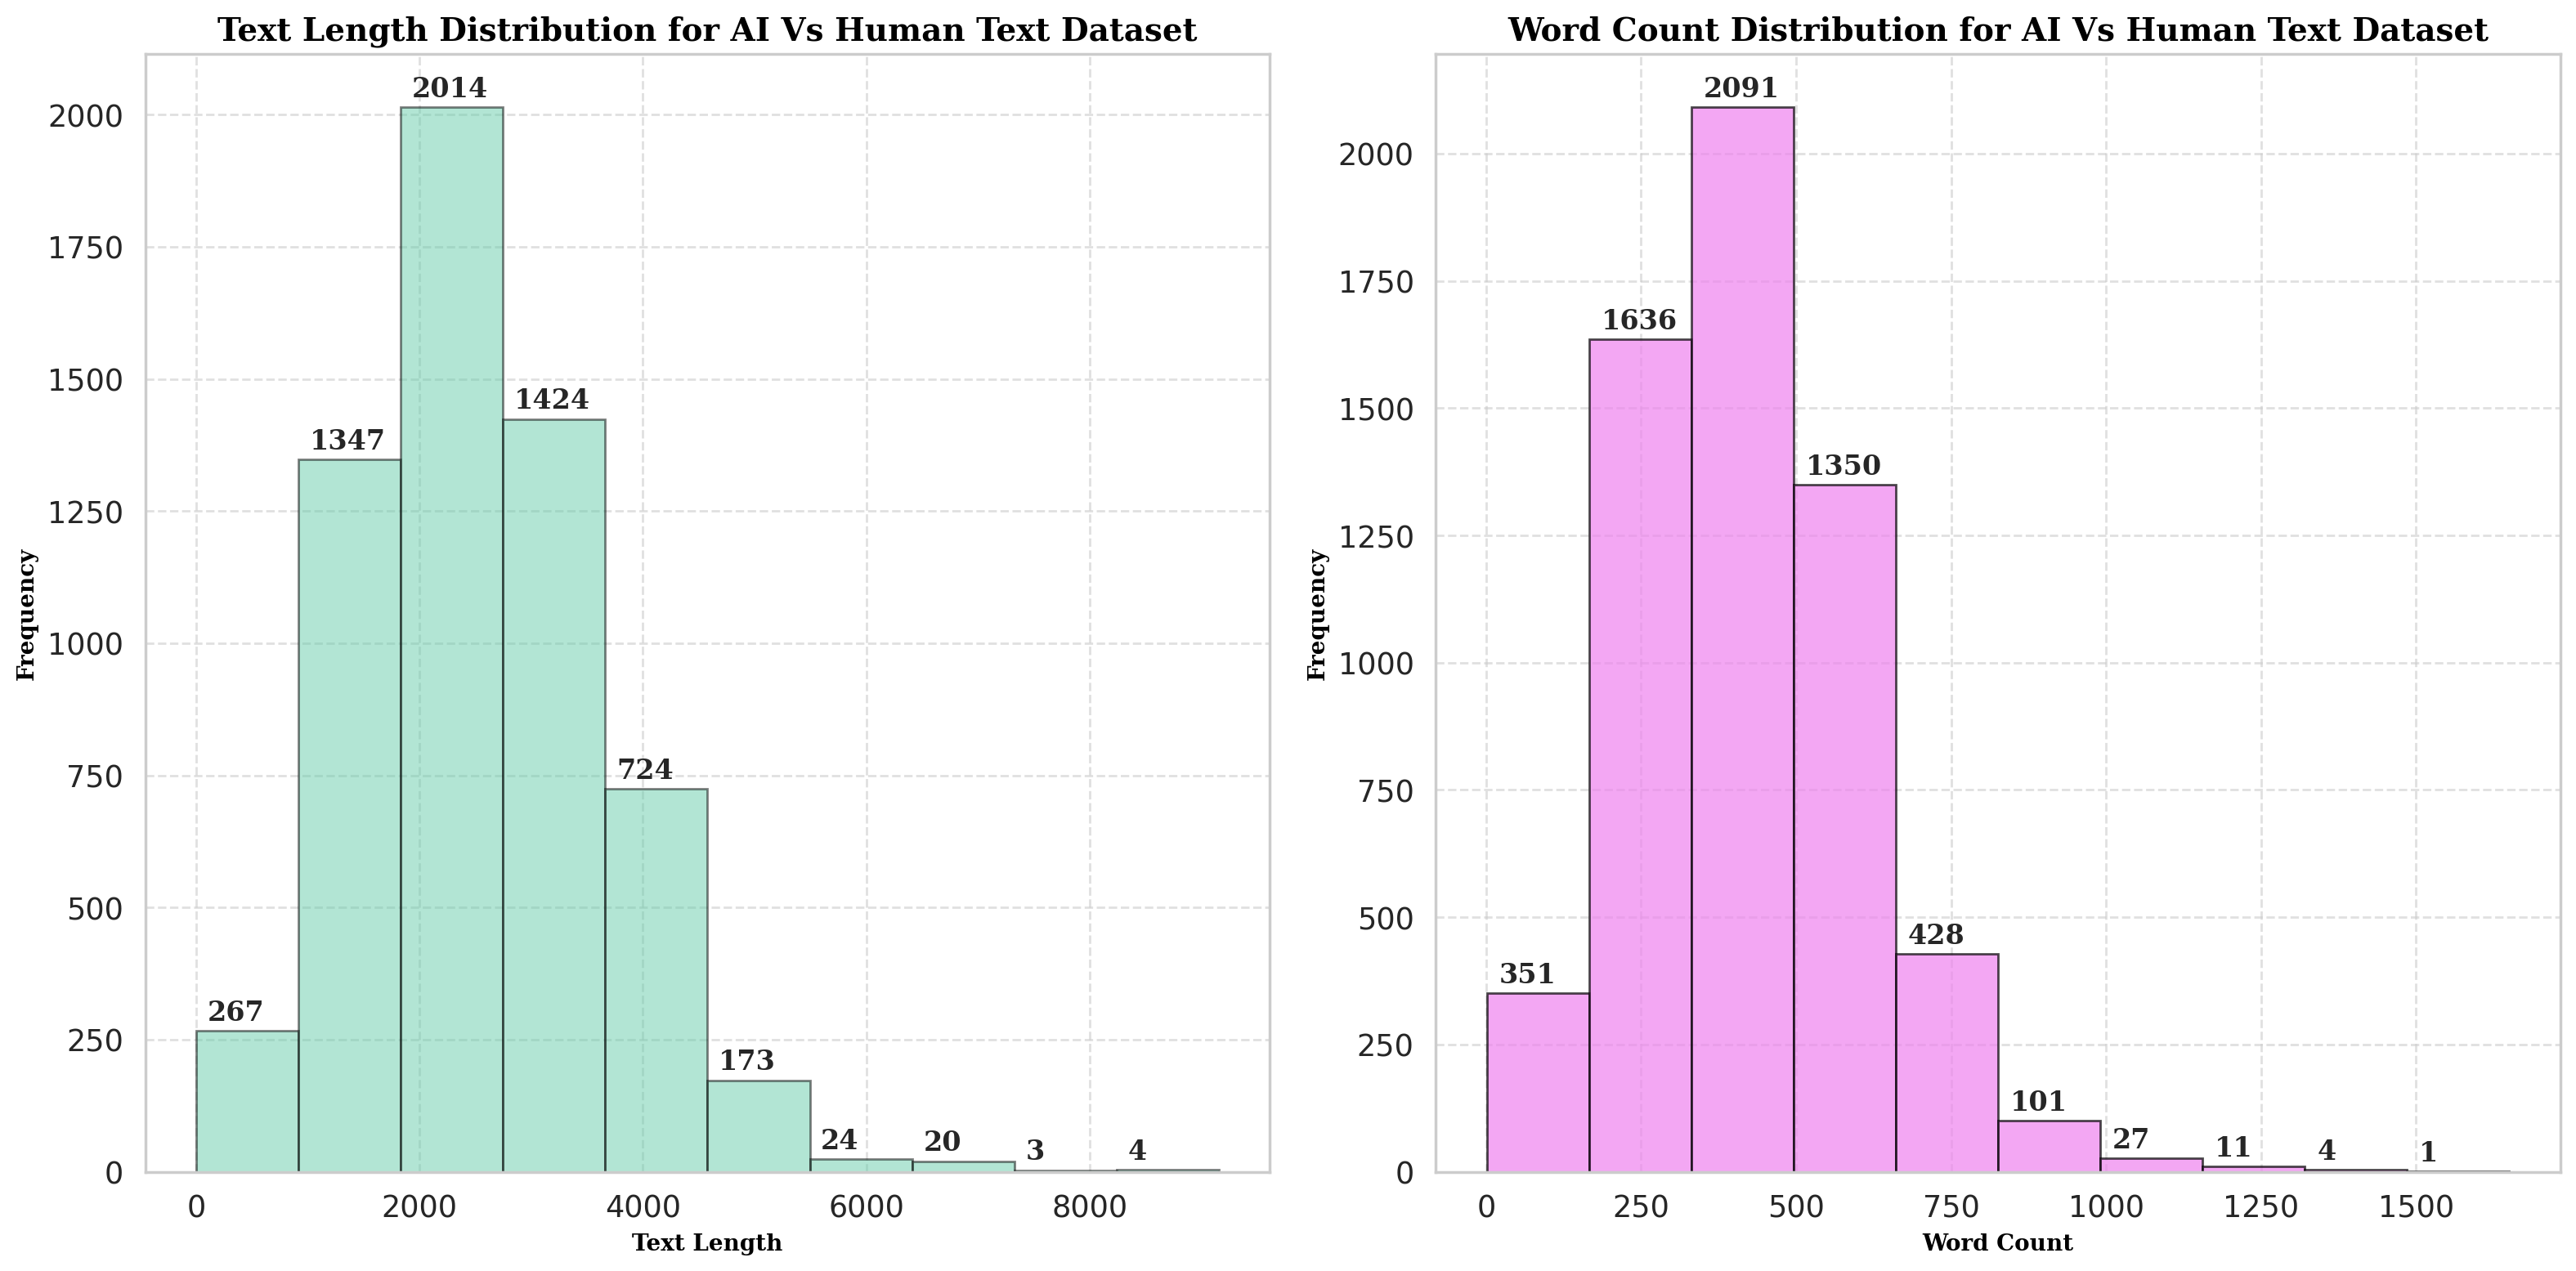

In [11]:
visualize_text_data(df, 'AI Vs Human Text Dataset')

In [12]:
from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    # Specify a Bangla-supported font, such as "Siyam Rupali"



    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black', #black
                          colormap='YlGnBu_r', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()

# **Wordcloud for AI Content**

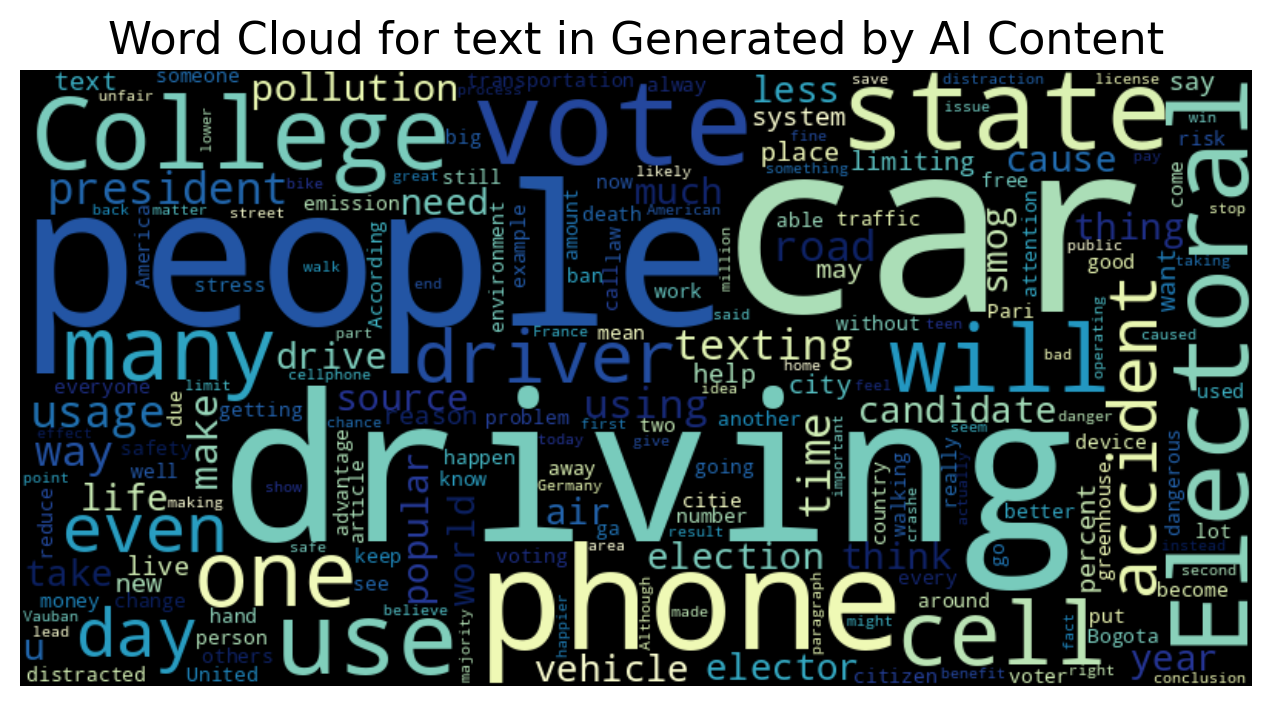

In [67]:
create_wordcloud(df_0, 'text', 'Generated by AI Content')

# **Wordcloud for Human Content**

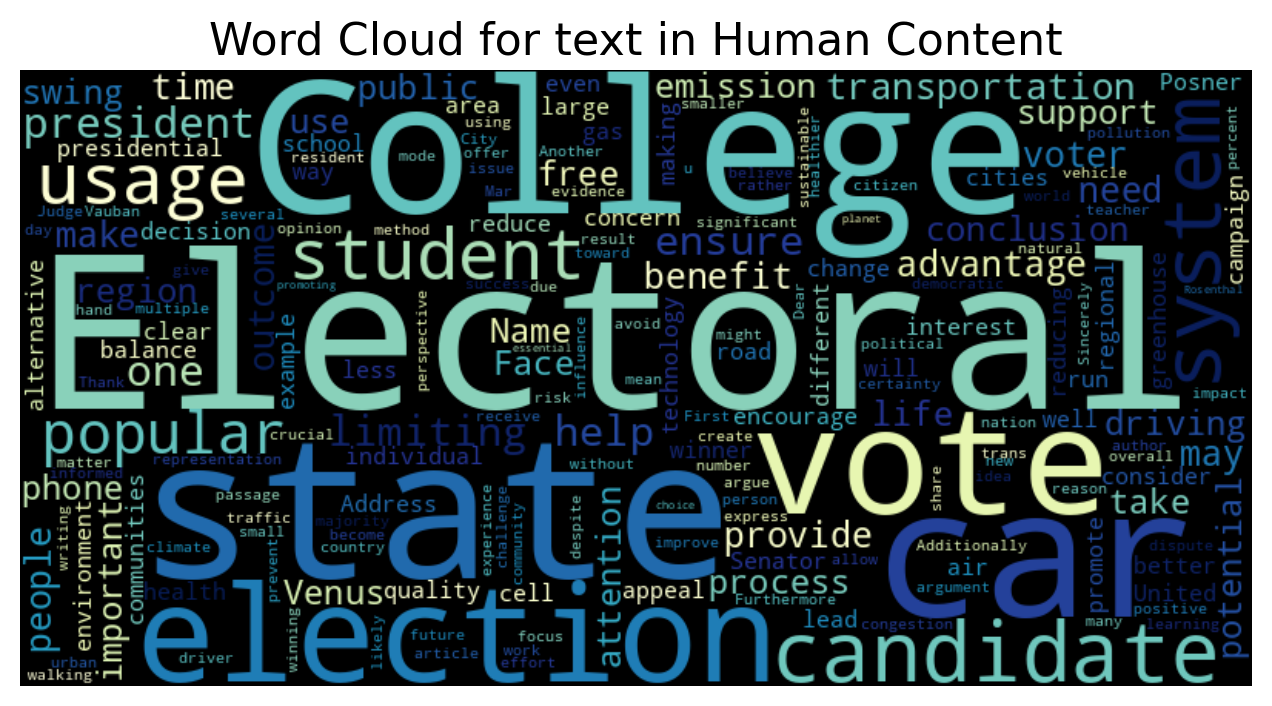

In [69]:
create_wordcloud(df_1, 'text', 'Human Content')

In [14]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import AutoTokenizer, RobertaModel
from transformers import RobertaTokenizer
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [36]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [16]:
sample_txt = 'Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.'

In [17]:
tokenizer = tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [18]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.
   Tokens: ['Trump', 'campaign', 'ad', '##viser', 'George', 'Papa', '##do', '##pou', '##los', 'told', 'an', 'Australian', 'diplomat', 'in', 'May', '2016', 'that', 'Russia', 'had', 'political', 'dir', '##t', 'on', 'Democratic', 'presidential', 'candidate', 'Hillary', 'Clinton', ',', 'the', 'New', 'York', 'Times', 'reported', 'on', 'Saturday', '.']
Token IDs: [29846, 17323, 10840, 54478, 10955, 17429, 10317, 73535, 13788, 21937, 10151, 12829, 45652, 10106, 10725, 10255, 10189, 14664, 10374, 13736, 15895, 10123, 10135, 19281, 36476, 22102, 72734, 24139, 117, 10105, 10287, 10482, 12020, 15943, 10135, 24848, 119]


In [19]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
token_lens = []

for txt in df.text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512,truncation=True)
      token_lens.append(len(tokens))

In [22]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

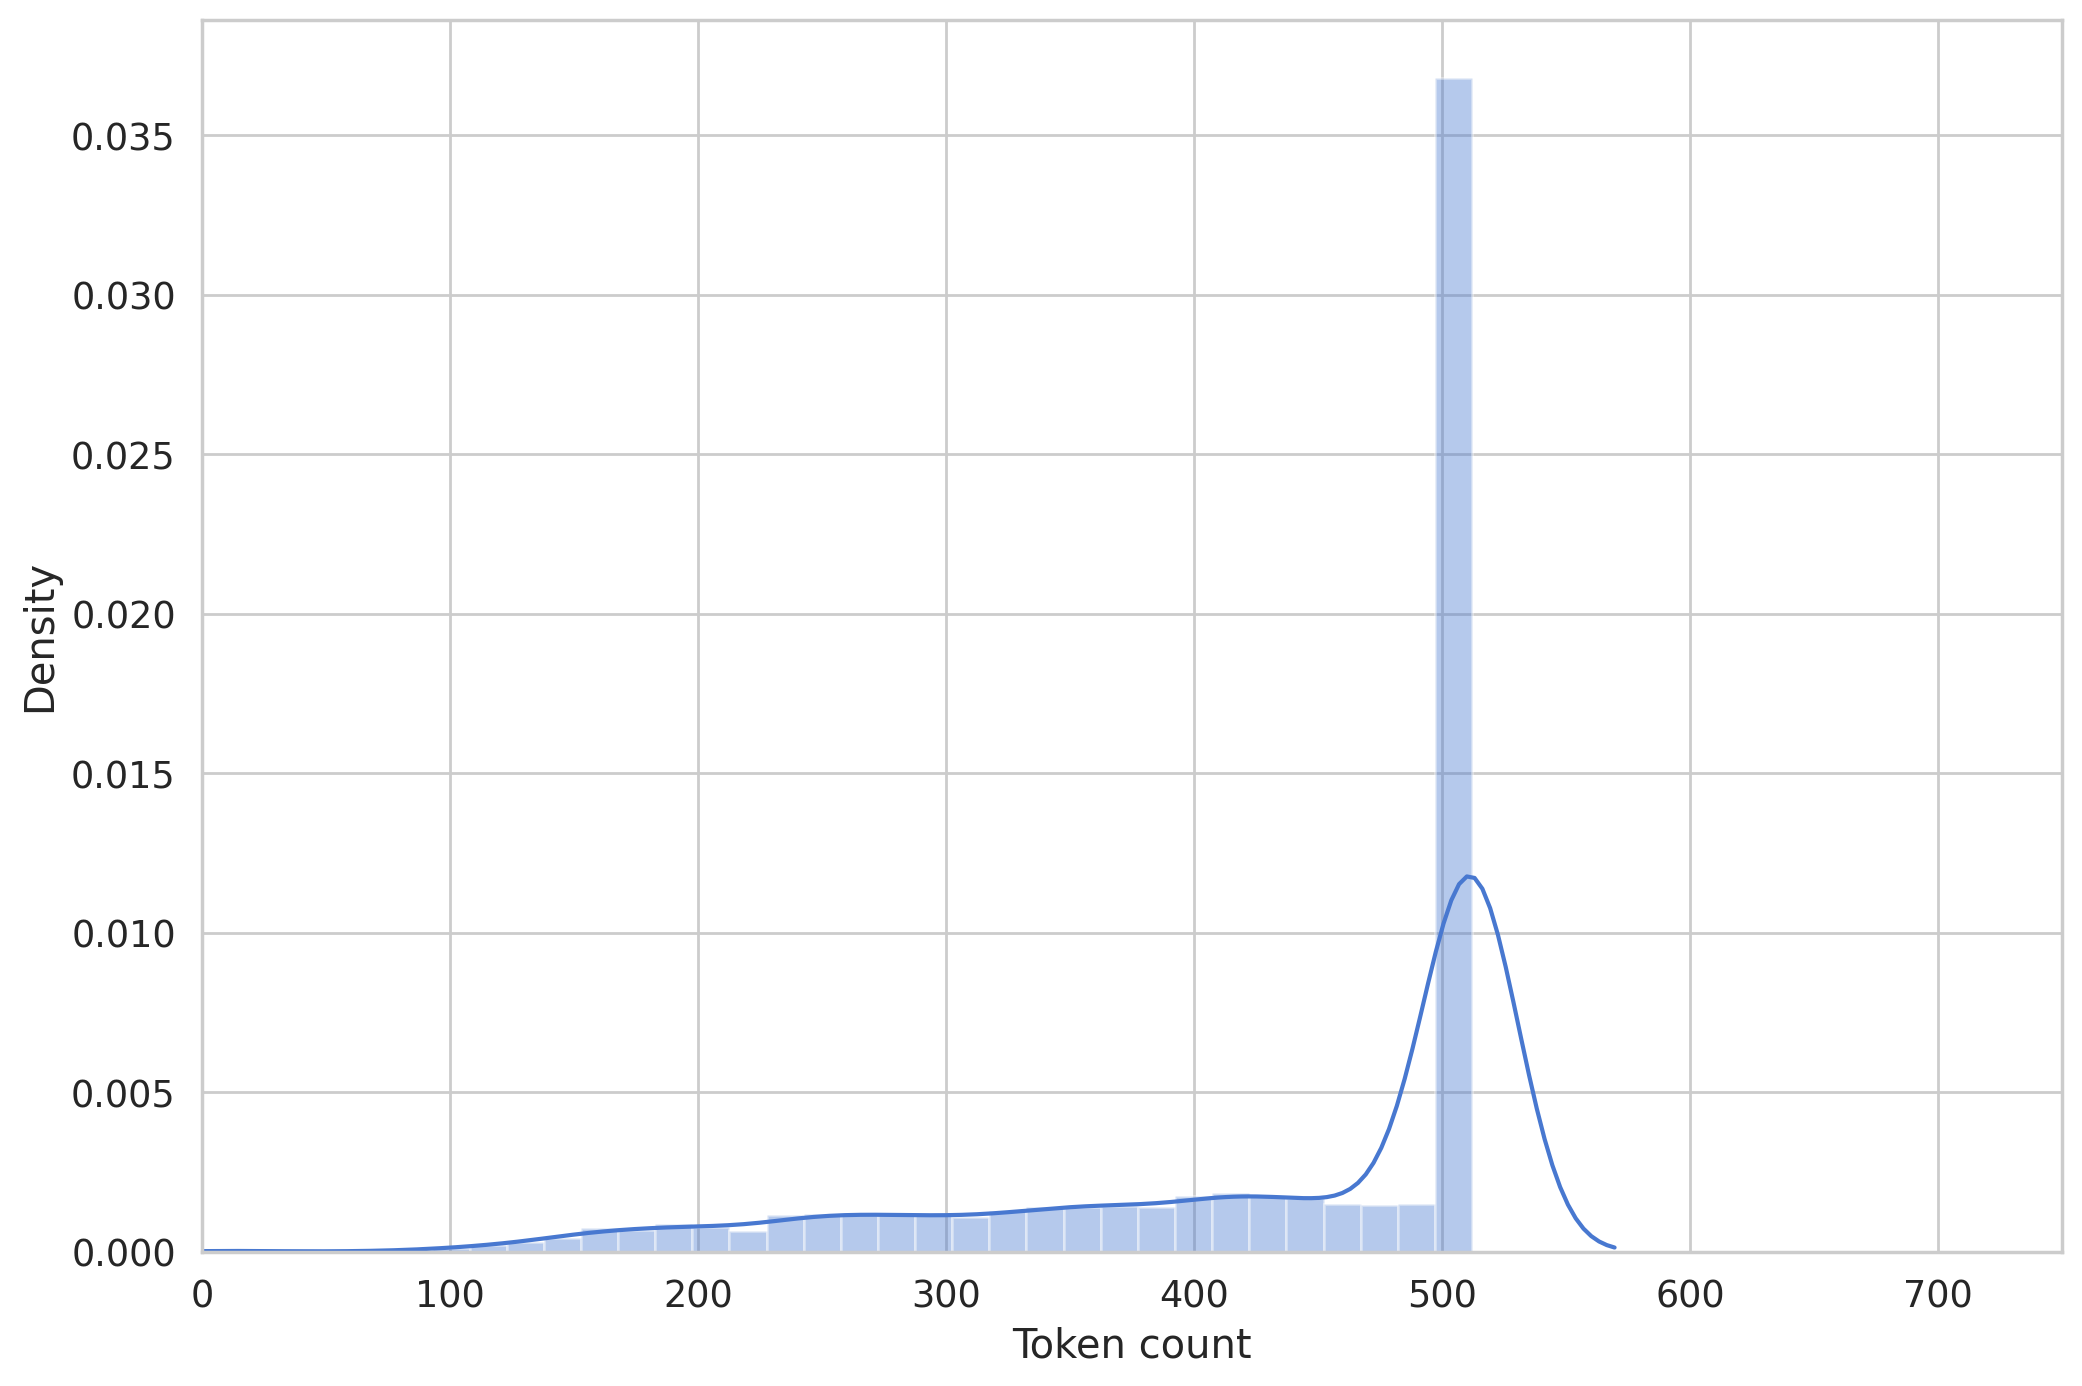

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 750]);
plt.xlabel('Token count');

In [24]:
MAX_LEN = 512

In [25]:
class Ai_vs_Human_dataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [26]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [27]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Ai_vs_Human_dataset(
    text=df.text.to_numpy(),
    targets=df.generated.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [28]:
import warnings

# Ignore the specific FutureWarning related to truncation
warnings.filterwarnings("ignore", message="Truncation was not explicitly activated*")

In [29]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [30]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [32]:
warnings.filterwarnings("ignore")

In [37]:
from transformers import RobertaModel, RobertaTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [38]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [39]:
last_hidden_state

BertForPreTrainingOutput(loss=None, prediction_logits=tensor([[[-11.1045, -10.9274, -11.1294,  ..., -11.1580, -10.4450, -10.8798],
         [-12.6464, -12.1727, -12.8090,  ..., -13.3262,  -9.5630, -11.9947],
         [-12.7024, -12.7112, -13.1337,  ..., -14.0642, -10.7981, -11.4612],
         ...,
         [-11.4355, -11.2431, -11.0939,  ..., -10.4247,  -9.7767,  -9.9364],
         [-12.7983, -12.7891, -13.1130,  ..., -11.0403, -10.5870, -11.6441],
         [-11.5741, -11.2672, -11.4202,  ...,  -9.9949,  -9.4003, -10.2871]]],
       grad_fn=<ViewBackward0>), seq_relationship_logits=tensor([[ 0.3568, -2.5426]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [42]:
class Ai_Human_textClassifier(nn.Module):

  def __init__(self, n_classes):
    super(Ai_Human_textClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [43]:
model = Ai_Human_textClassifier(2)
model = model.to(device)

In [44]:
bert_model.config.hidden_size

768

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [46]:
F.softmax(model(input_ids, attention_mask), dim=1) 

tensor([[0.3284, 0.6716],
        [0.4226, 0.5774],
        [0.3968, 0.6032],
        [0.3445, 0.6555],
        [0.4455, 0.5545],
        [0.4361, 0.5639],
        [0.4199, 0.5801],
        [0.4555, 0.5445]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [47]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [49]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


# **Training**

In [50]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------


Training: 100%|██████████| 525/525 [03:50<00:00,  2.28batch/s, loss=0.257]


Train loss 0.2570528610463121 accuracy 0.9283333333333333


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.03batch/s, loss=0.224]


Val   loss 0.22352504865183964 accuracy 0.9433333333333334

Epoch 2/10
----------


Training: 100%|██████████| 525/525 [03:50<00:00,  2.27batch/s, loss=0.0749]


Train loss 0.07486338202032217 accuracy 0.9847619047619047


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.04batch/s, loss=0.0836]


Val   loss 0.08355258659957249 accuracy 0.9833333333333333

Epoch 3/10
----------


Training: 100%|██████████| 525/525 [03:50<00:00,  2.27batch/s, loss=0.0457]


Train loss 0.04567417467686547 accuracy 0.9904761904761905


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.01batch/s, loss=0.0641]


Val   loss 0.06410940652362904 accuracy 0.9888888888888889

Epoch 4/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=0.0186]


Train loss 0.018619979228671927 accuracy 0.9969047619047618


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  6.97batch/s, loss=0.047] 


Val   loss 0.046990963878469086 accuracy 0.9922222222222222

Epoch 5/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=0.0122] 


Train loss 0.012172244750392911 accuracy 0.9978571428571429


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.00batch/s, loss=0.0127] 


Val   loss 0.012720787374867308 accuracy 0.9977777777777778

Epoch 6/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=0.002]  


Train loss 0.001996996016581155 accuracy 0.9997619047619047


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  6.99batch/s, loss=0.004]  


Val   loss 0.0039970151279639324 accuracy 0.9977777777777778

Epoch 7/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=4.67e-5]


Train loss 4.671170157616004e-05 accuracy 1.0


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  6.98batch/s, loss=0.00411]


Val   loss 0.004106686381483811 accuracy 0.9988888888888889

Epoch 8/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=3.45e-5]


Train loss 3.451932996367326e-05 accuracy 1.0


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.02batch/s, loss=0.00418]


Val   loss 0.004181825728359142 accuracy 0.9988888888888889

Epoch 9/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=2.83e-5]


Train loss 2.8300035666602308e-05 accuracy 1.0


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.01batch/s, loss=0.00436]


Val   loss 0.004358802362964195 accuracy 0.9988888888888889

Epoch 10/10
----------


Training: 100%|██████████| 525/525 [03:51<00:00,  2.27batch/s, loss=2.5e-5] 


Train loss 2.5002601621617076e-05 accuracy 1.0


Evaluating: 100%|██████████| 113/113 [00:16<00:00,  7.03batch/s, loss=0.00417]

Val   loss 0.0041664562352634995 accuracy 0.9988888888888889

CPU times: user 40min 40s, sys: 30.5 s, total: 41min 11s
Wall time: 41min 21s


# **Evaluation**

In [51]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [52]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 113/113 [00:16<00:00,  6.98batch/s, loss=0.000539]


1.0

In [53]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# **Classification report**

In [55]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

                 precision    recall  f1-score   support

          Human     1.0000    1.0000    1.0000       465
Generated by AI     1.0000    1.0000    1.0000       435

       accuracy                         1.0000       900
      macro avg     1.0000    1.0000    1.0000       900
   weighted avg     1.0000    1.0000    1.0000       900



# **Confusion matrix**

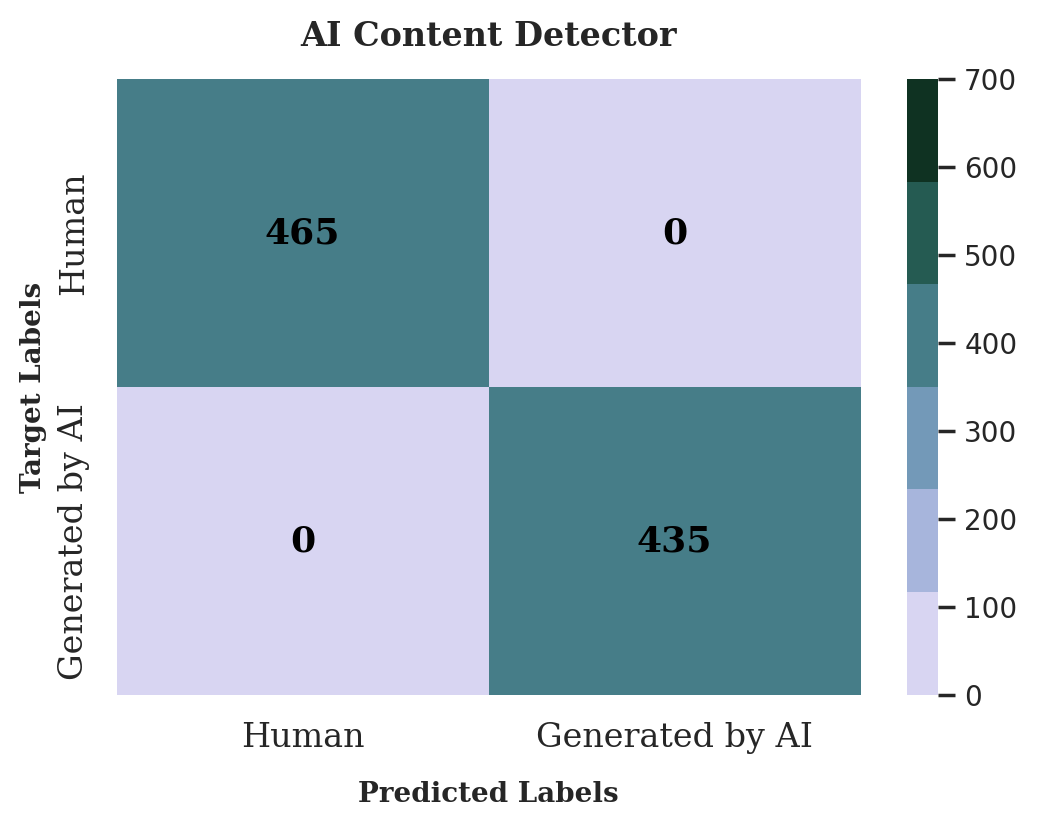

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.cubehelix_palette(start=2)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=700,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('AI Content Detector', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()
